<a href="https://colab.research.google.com/github/Astrocitos/Advanced-ML-Practices/blob/main/TC5033_Activity3b_ID40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TC 5033
### Word Embeddings

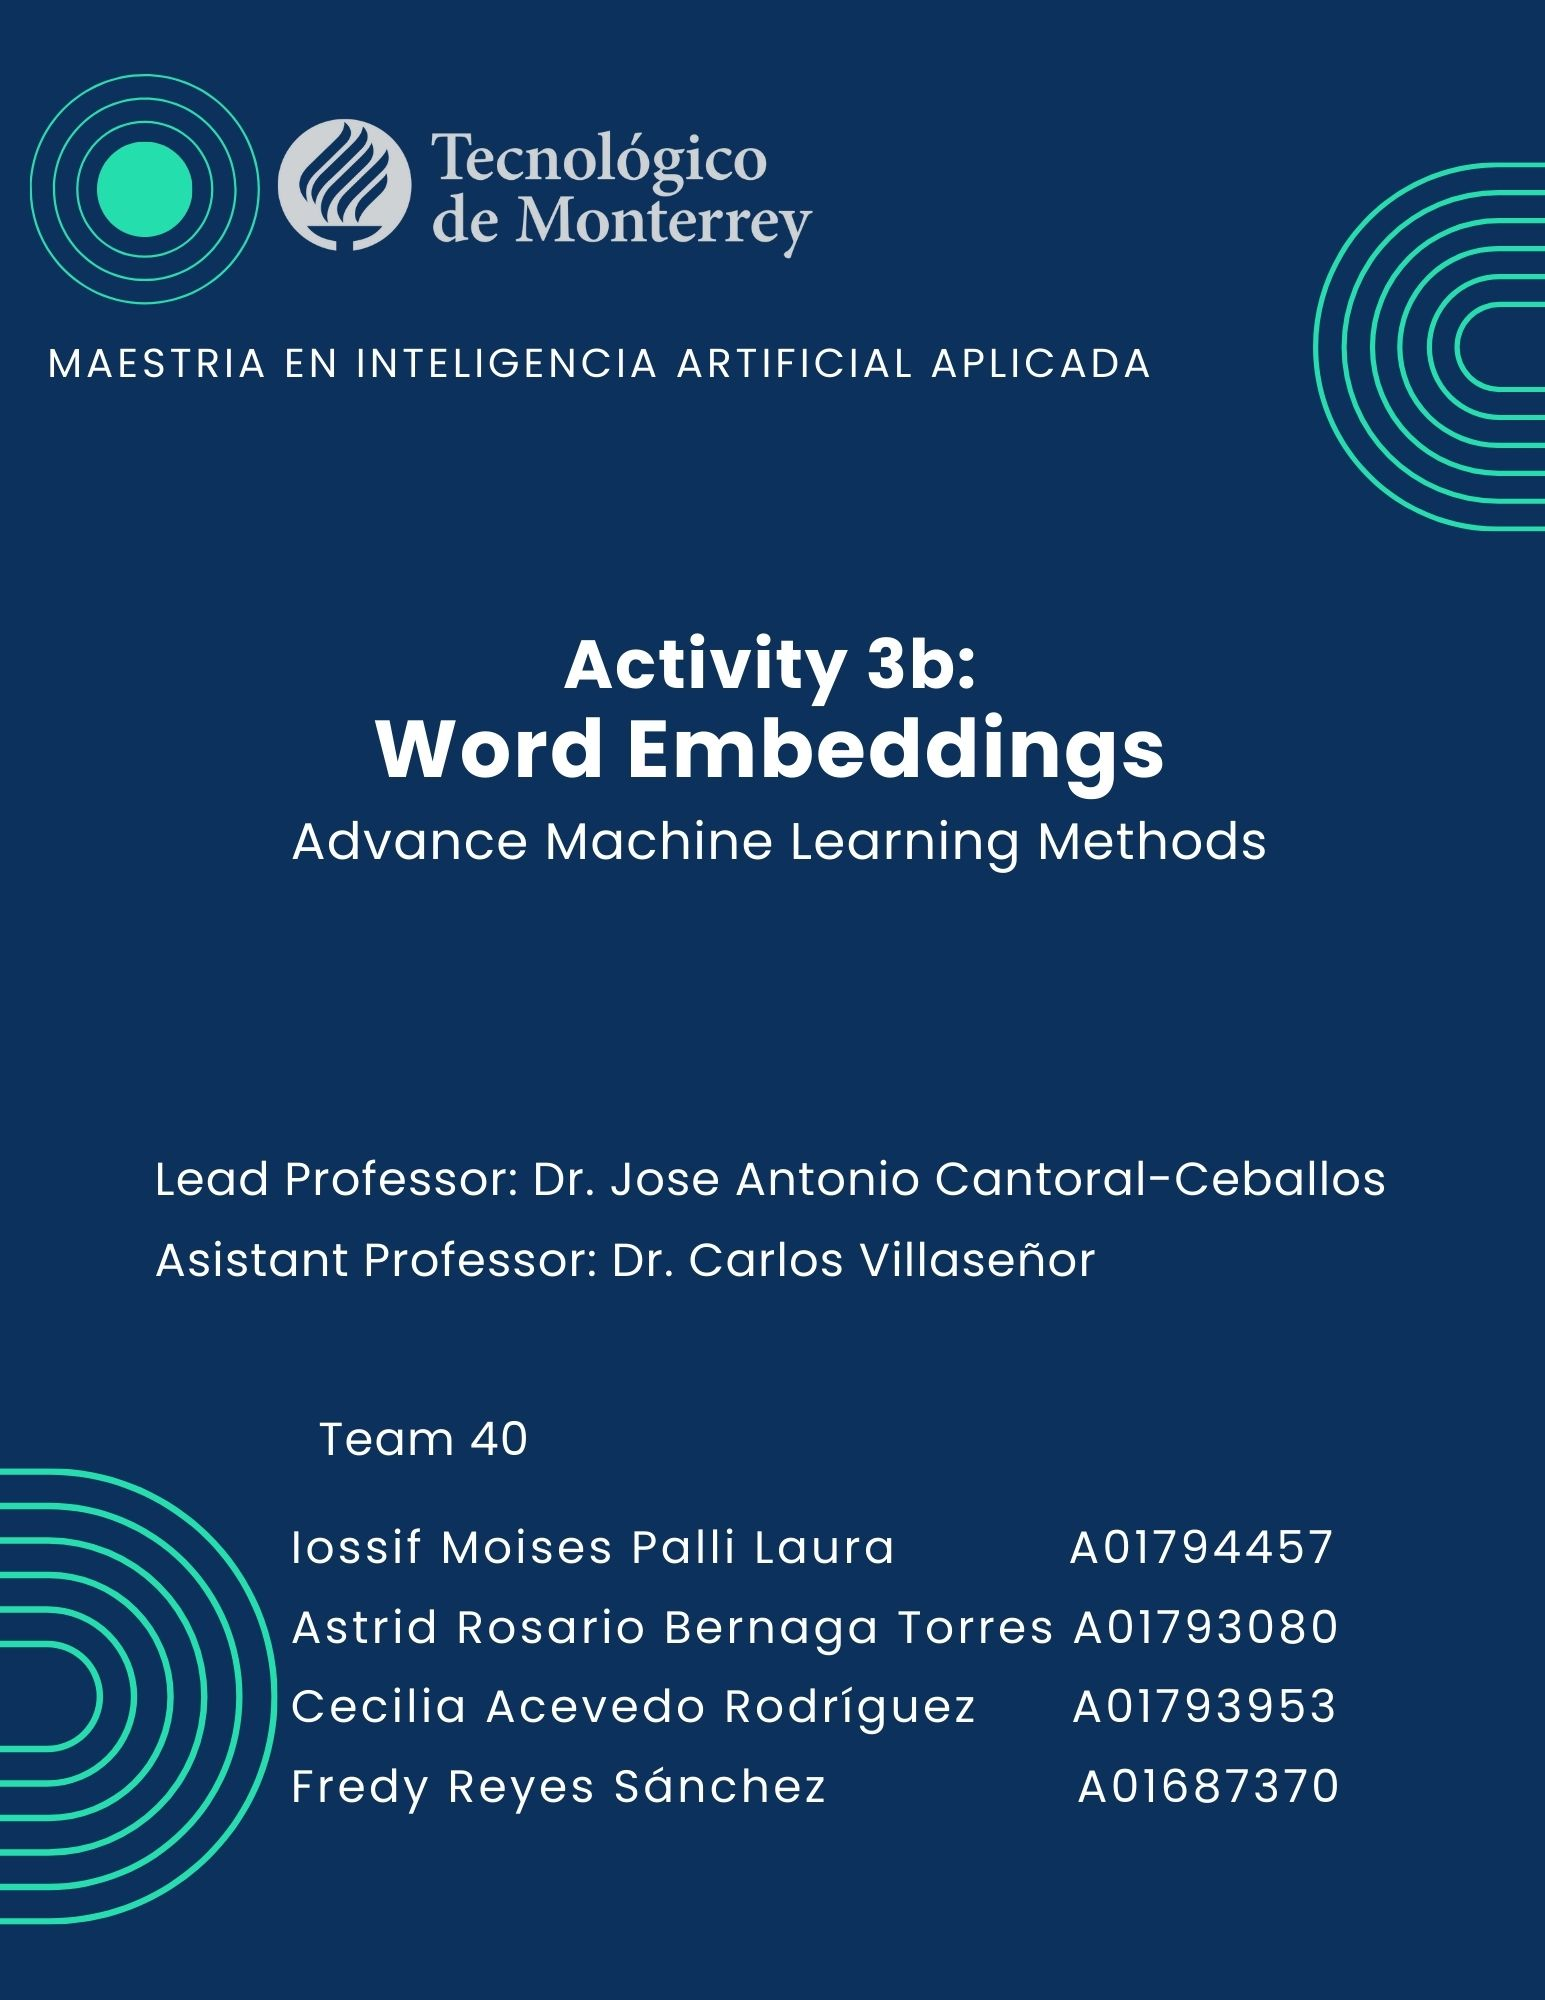

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


#Introduction

In this activity, we will explore the use of Recurrent Neural Networks (RNNs) for text classification using the AG_NEWS dataset in PyTorch. Text classification is a common natural language processing (NLP) task, where the goal is to categorize text documents into predefined categories or classes. In this case, we will focus on classifying news articles into four categories: World, Sports, Business, and Sci/Tech.

#**Enviroment Setup**

**Install required libraries**


In [1]:
!pip install torch

In [2]:
!pip install  pytorch torchtext

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects


In [3]:
!pip install  pytorch torchdata

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects


In [4]:
!pip install pytorch torchvision torchaudio

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects


In [5]:
!pip install scikit-plot

In [6]:
!pip install portalocker

In [7]:
!pip install lime

### Import libraries

In [8]:
# Import NumPy for numerical operations
import numpy as np

# Import PyTorch and related modules for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

# Import PyTorchText for text processing
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

# Import PyTorch's functional module
from torch.nn import functional as F

# Import scikit-learn for evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Import scikit-plot for plotting
import scikitplot as skplt

# Import Python's garbage collector module
import gc

# Import LIME for text explanations
from lime import lime_text

# Import Matplotlib for visualization
import matplotlib.pyplot as plt

# Import tqdm for progress bars
from tqdm import tqdm

In [9]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

#Data Preparation

We will start by loading and preparing the AG_NEWS dataset. This step involves tokenizing the text, building a vocabulary, and creating data loaders for training and evaluation.

In [65]:
# Load AG_NEWS dataset
from torchtext.datasets import AG_NEWS
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [66]:
# Tokenizer setup
tokeniser = get_tokenizer('basic_english')

# Create vocabulary
def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [67]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])

#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [68]:
#test tokens
tokens = tokeniser('Welcome to TE3007')
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


In [69]:
# Define class labels and max token length
labels = ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50

In [70]:
# Define batch size
BATCH_SIZE = 256

In [71]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [72]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [73]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [74]:
# Data loaders and collate function
def collate_batch(batch):
    y, x = list(zip(*batch))

    # Convert y to tensor (assuming it's a list of integers)
    y = torch.tensor(y, dtype=torch.long) - 1

    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.long), y

In [75]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

#Model Setup:

We will define a Recurrent Neural Network (RNN) model for text classification.  The model will take tokenized text sequences as input and produce class predictions.



In [76]:
class RNN_Model(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),embedding_dim=embed_size)

        # Completa la capa RNN (puedes usar nn.GRU(), nn.RNN(), o nn.LSTM())
        self.rnn = nn.GRU(input_size=embed_size, hidden_size=hidden, num_layers=layers, batch_first=True)

        # Completa la capa completamente conectada (output classifier)
        self.fc = nn.Linear(hidden, num_classes)

    def forward(self, x):
        x = self.embedding_layer(x)
        # Implementa el pase hacia adelante a través de la capa RNN
        output, _ = self.rnn(x)
        # Toma el último estado oculto como representación de la secuencia
        last_hidden_state = output[:, -1, :]
        # Pase hacia adelante a través de la capa completamente conectada
        out = self.fc(last_hidden_state)
        return out

#Accuracy Function

We will implement a function to calculate the accuracy of our model's predictions compared to the ground truth labels. This function will be used to evaluate the model's performance.

In [77]:
# Accuracy calculation function
def accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

#Training Function

We will create a training function that iterates over the dataset and updates the model's weights using backpropagation. The goal is to train the model to achieve an accuracy of at least 70%.

In [78]:
# Training function
def train(model, optimiser, epochs=100):
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

In [79]:
# Hyperparameters
EMBEDDING_SIZE = 100
NEURONS = 128
LAYERS = 2
NUM_CLASSES = len(labels)
lr = 0.001
epochs = 5

Epoch 1, Loss: 0.7056, Train Accuracy: 0.6990


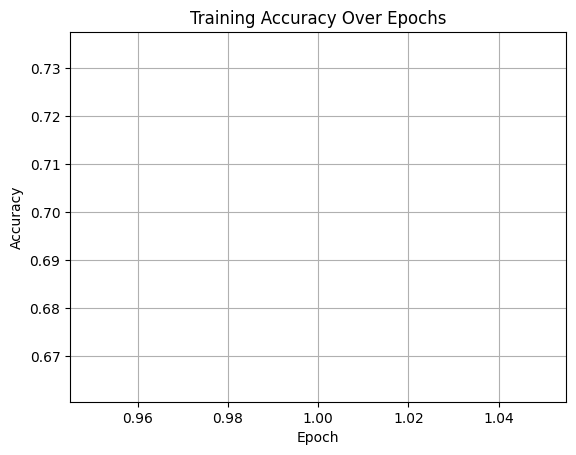

Epoch 2, Loss: 0.2968, Train Accuracy: 0.8981


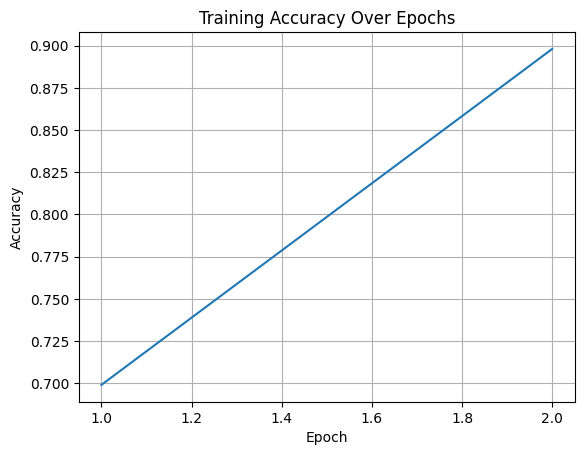

Epoch 3, Loss: 0.2203, Train Accuracy: 0.9247


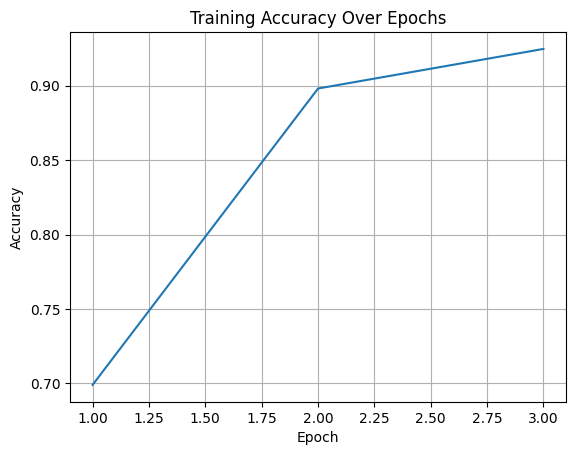

Epoch 4, Loss: 0.1717, Train Accuracy: 0.9419


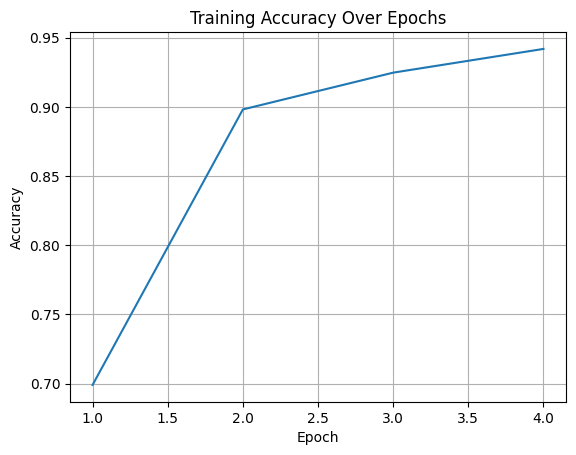

Epoch 5, Loss: 0.1352, Train Accuracy: 0.9548


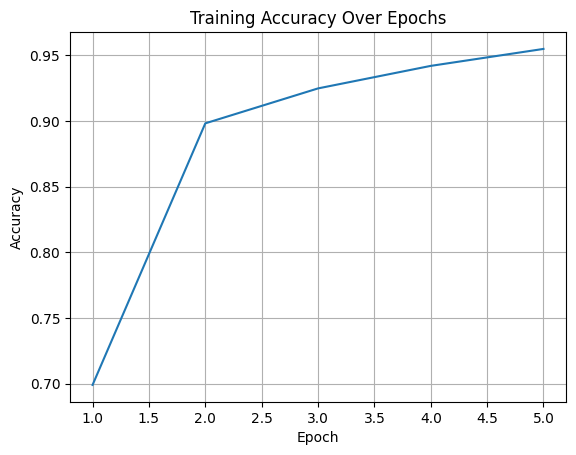

In [80]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Initialize and train the RNN model
rnn_model = RNN_Model(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)

# Initialize an empty list to store accuracy values during training
train_accuracy_history = []

for epoch in range(epochs):
    # Create a tqdm progress bar for the training loop
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)

    rnn_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(progress_bar, 0):
        inputs, labels = data
        optimiser.zero_grad()
        outputs = rnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        running_loss += loss.item()

        # Calculate accuracy on the training set
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update the progress bar
        progress_bar.set_postfix(loss=f'{running_loss / (i + 1):.4f}', accuracy=f'{correct / total:.4f}')

    # Append the training accuracy to the history
    train_accuracy_history.append(correct / total)

    # Close the tqdm progress bar for this epoch
    progress_bar.close()

    # Print the loss and accuracy for this epoch
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {correct / total:.4f}')

    # Plot the training accuracy over epochs
    plt.plot(range(1, epoch + 2), train_accuracy_history)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.grid(True)
    plt.show()

In [81]:
# Calculate accuracy
test_accuracy = accuracy(rnn_model, test_loader)
print(f'Final Test Accuracy: {test_accuracy:.4f}')

Final Test Accuracy: 0.9083


Evaluate Performance

In [83]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(rnn_model, test_loader)

In [86]:
target_classes = ["World", "Sports", "Business", "Sci/Tech"]
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.9082894736842105

Classification Report : 
              precision    recall  f1-score   support

       World       0.92      0.91      0.92      1900
      Sports       0.95      0.97      0.96      1900
    Business       0.87      0.88      0.88      1900
    Sci/Tech       0.88      0.87      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600


Confusion Matrix : 
[[1734   48   67   51]
 [  15 1848   20   17]
 [  66   19 1666  149]
 [  63   30  152 1655]]


#Text Sampling
We will write a function that allows us to input sample text and classify it using our trained model. This step demonstrates how the model can be used for real-world applications.


In [96]:
labels = ["World", "Sports", "Business", "Sci/Tech"]

In [97]:
max_words = 15

# Create a LIME Text Explainer
explainer = lime_text.LimeTextExplainer(class_names=labels, verbose=True)

# Function to make predictions on a batch of text
def make_predictions(X_batch_text):
    # Tokenize and preprocess the input text
    X = [vocab(tokenizer(text)) for text in X_batch_text]
    X = [tokens + ([0] * (max_words - len(tokens))) if len(tokens) < max_words else tokens[:max_words] for tokens in X]

    # Forward pass through the model to get predictions
    logits = rnn_model(torch.tensor(X, dtype=torch.int32))
    preds = F.softmax(logits, dim=-1)

    return preds.detach().numpy()

# Generate a random index for testing
rng = np.random.RandomState(1)
idx = rng.randint(1, len(X_test_text))

# Preprocess and classify a sample text
X = [vocab(tokenizer(text)) for text in X_test_text[idx:idx+1]]
X = [tokens + ([0] * (max_words - len(tokens))) if len(tokens) < max_words else tokens[:max_words] for tokens in X]

# Forward pass through the model
preds = rnn_model(torch.tensor(X, dtype=torch.int32))
preds = F.softmax(preds, dim=-1)

# Print the prediction and actual label
print("Prediction : ", labels[preds.argmax()])
print("Actual :     ", labels[Y_test[idx]])

Prediction :  Business
Actual :      Business


In [98]:
explanation = explainer.explain_instance(X_test_text[idx], classifier_fn=make_predictions,
                                         labels=Y_test[idx:idx+1])
explanation.show_in_notebook()

Intercept 0.36272411431545803
Prediction_local [0.87370286]
Right: 0.8503804


#Confusion Matrix:
Finally, we will implement a function to create a confusion matrix for our model's predictions on the test data. This matrix will help us analyze the most common mistakes made by the model, providing insights into its performance.

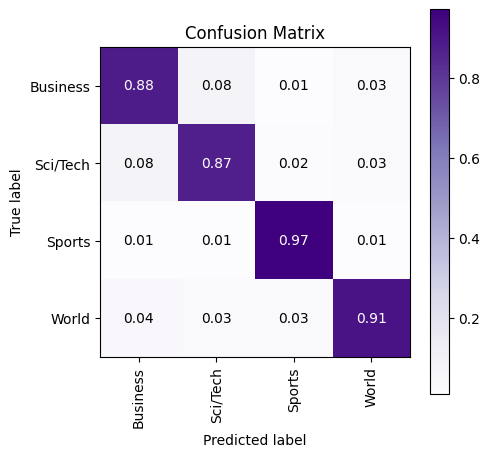

In [99]:
# Plot the confusion matrix
skplt.metrics.plot_confusion_matrix([labels[i] for i in Y_actual], [labels[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

# Conclusion

In conclusion, this activity provided hands-on experience in building and training an RNN-based text classification model using PyTorch.

The model achieved a final test accuracy of approximately 90.83%, surpassing the 70% target.

The text sampling function demonstrated the model's ability to classify new text samples.

The confusion matrix analysis revealed that the model performed well across different classes, with few misclassifications.

Overall, this activity showcased the effectiveness of RNNs in text classification tasks and highlighted the importance of data preprocessing, model training, and result analysis in the NLP domain.